In [1]:
import os
import scanpy as sc
import scipy.io
import scipy.sparse as sp
import pandas as pd 
import numpy as np
import anndata
import matplotlib.pyplot as plt


Set directory variables for the samples

In [24]:
def set_directories(patient_id, base_dir):
    """
    Generate a dictionary containing paths to relevant directories for a given patient.
    
    Parameters:
    - patient_id (str): The unique identifier for the patient.
    - base_dir (str): The base directory containing all patient data.
    
    Returns:
    - dict: A dictionary with paths to gene expression, dextramer, TCR, and CITE-seq data.
    """
    return {
        "dir_gex": os.path.join(base_dir, f"{patient_id}/CellRangerGex_results"),
        "dir_dex": os.path.join(base_dir, f"{patient_id}_dextramer_count/umi_count"),
        "dir_TCR": os.path.join(base_dir, f"{patient_id}_TCR_VDJ/CellRangerVdj_results"),
        "dir_CITE": os.path.join(base_dir, f"{patient_id}_hash_count/umi_count")
    }

# Define base directory and patient IDs
base_dir = "/Users/ecrosse/Desktop/"

# Set directories for each patient
dirs_SRSF2_9 = set_directories("data_for_edie_third_batch_january/WJK-2859_SRSF2_9", base_dir)
dirs_SRSF2_10 = set_directories("dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10", base_dir)

# Print to verify the directory structure
print(dirs_SRSF2_9)
print(dirs_SRSF2_10)


{'dir_gex': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_hash_count/umi_count'}
{'dir_gex': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10/CellRangerGex_results', 'dir_dex': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_dextramer_count/umi_count', 'dir_TCR': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_TCR_VDJ/CellRangerVdj_results', 'dir_CITE': '/Users/ecrosse/Desktop/dextramer_data_for_edie_january_part_2/WJK-2864_SRSF2_10_hash_count/umi_count'}


Load gene expression into adata

In [25]:
# Define paths
dir_gex = dirs_SRSF2_9["dir_gex"]
dir_dex = dirs_SRSF2_9["dir_dex"]
dir_CITE = dirs_SRSF2_9["dir_CITE"]

print(dir_gex)
print(dir_dex)
print(dir_CITE)

adata = sc.read_10x_h5(os.path.join(dir_gex, "filtered_feature_bc_matrix.h5"))
adata.var_names_make_unique()
adata

/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9/CellRangerGex_results
/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_dextramer_count/umi_count
/Users/ecrosse/Desktop/data_for_edie_third_batch_january/WJK-2859_SRSF2_9_hash_count/umi_count


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1900: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 8008 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

Load CITE and Dextramer data

In [26]:
# Load CITE-seq data
cite_matrix = scipy.io.mmread(f"{dir_CITE}/matrix.mtx.gz").T.tocsr()
cite_barcodes = pd.read_csv(f"{dir_CITE}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
cite_features = pd.read_csv(f"{dir_CITE}/features.tsv.gz", header=None, sep='\t')[1].values

# Load Dextramer data
dex_matrix = scipy.io.mmread(f"{dir_dex}/matrix.mtx.gz").T.tocsr()
dex_barcodes = pd.read_csv(f"{dir_dex}/barcodes.tsv.gz", header=None, sep='\t')[0].values + "-1"
dex_features = pd.read_csv(f"{dir_dex}/features.tsv.gz", header=None, sep='\t')[1].values

# Find common barcodes across all datasets
common_barcodes = list(set(adata.obs_names) & set(cite_barcodes) & set(dex_barcodes))

# Subset adata to common barcodes
adata = adata[adata.obs_names.isin(common_barcodes)].copy()

# Ensure barcodes are in the same order
cite_indices = np.array([np.where(cite_barcodes == bc)[0][0] for bc in adata.obs_names])
dex_indices = np.array([np.where(dex_barcodes == bc)[0][0] for bc in adata.obs_names])

cite_matrix = cite_matrix[cite_indices, :]
dex_matrix = dex_matrix[dex_indices, :]

# Store multimodal data in .obsm
adata.obsm["CITE"] = cite_matrix
adata.obsm["Dextramer"] = dex_matrix

# Store feature names in .uns
adata.uns["CITE_features"] = cite_features
adata.uns["Dextramer_features"] = dex_features

print("CITE-seq and Dextramer data successfully added to anndata.")



CITE-seq and Dextramer data successfully added to anndata.


Write raw adata

In [28]:
adata.write("adata_raw.h5ad")

QC steps

In [29]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [30]:
print(adata.obs.describe())

       n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt
count        7992.000000   7992.000000      7992.000000    7992.000000
mean         1840.969094   4664.024902        42.327953       1.058015
std           688.167250   2522.644531        40.968998       1.335171
min            40.000000    500.000000         0.000000       0.000000
25%          1481.000000   3430.000000        11.000000       0.309042
50%          1794.000000   4375.000000        36.000000       0.857646
75%          2104.250000   5321.250000        61.000000       1.360179
max          6367.000000  30498.000000       752.000000      27.407408


In [ ]:
sc.pp.filter_cells(adata, min_genes=250)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_counts=500)
# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalize data (log1p normalization)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000)

# Filter out genes starting with "TR"
variable_genes = adata.var["highly_variable"]
filtered_variable_genes = adata.var_names[variable_genes & ~adata.var_names.str.startswith("TR")]
# Update the list of highly variable genes
adata.var["highly_variable"] = adata.var_names.isin(filtered_variable_genes)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [36]:
# Scale the data
sc.pp.scale(adata, max_value=10)  # Scale all genes

VDJ integration

In [37]:
# set TCR dir
dir_TCR = dirs_SRSF2_9["dir_TCR"]


# Load V(D)J data
vdj = pd.read_csv(f"{dir_TCR}/filtered_contig_annotations.csv")

# Filtering steps
tcr = vdj[
    (vdj["high_confidence"] == True) & 
    (vdj["chain"].isin(["TRA", "TRB"])) & 
    (vdj["productive"] == True) & 
    (vdj["umis"] >= 3)
][["barcode", "chain", "raw_clonotype_id", 
   "v_gene", "d_gene", "j_gene", "c_gene", 
   "cdr1_nt", "cdr2_nt", "cdr3_nt"]]

# Group by raw_clonotype_id and filter for entries that contain both TRA and TRB chains
tcr = tcr.groupby("raw_clonotype_id").filter(lambda g: any(g["chain"] == "TRA") and any(g["chain"] == "TRB"))

# Reset index if needed
tcr = tcr.reset_index(drop=True)

# Print summary
print(tcr.head())

              barcode chain raw_clonotype_id    v_gene d_gene   j_gene c_gene  \
0  AAACCTGAGCCAGTAG-1   TRA     clonotype332   TRAV1-2    NaN   TRAJ12   TRAC   
1  AAACCTGAGCCAGTAG-1   TRB     clonotype332   TRBV6-1  TRBD2  TRBJ2-1  TRBC2   
2  AAACCTGAGGAGTTGC-1   TRA    clonotype1183  TRAV26-2    NaN   TRAJ49   TRAC   
3  AAACCTGAGGAGTTGC-1   TRB    clonotype1183    TRBV19  TRBD1  TRBJ2-7  TRBC2   
4  AAACCTGAGTACGACG-1   TRB       clonotype5    TRBV28    NaN  TRBJ1-1  TRBC1   

                 cdr1_nt             cdr2_nt  \
0     ACATCTGGGTTCAACGGG  AATGTTCTGGATGGTTTG   
1        ATGAACCATAACTCC  TCAGCTTCTGAGGGTACC   
2  ACAATCAGTGGAACTGATTAC     GGTCTTACAAGCAAT   
3        TTGAACCACGATGCC  TCACAGATAGTAAATGAC   
4        ATGGACCATGAAAAT  TCATATGATGTTAAAATG   

                                         cdr3_nt  
0           TGTGCTGGGATGGATAGCAGCTATAAATTGATCTTC  
1  TGTGCCAGCAGTGAACTAGCGGGAGGGTACAATGAGCAGTTCTTC  
2           TGCATCCTGAGAGACTCGGATAACCAGTTCTATTTT  
3  TGTGCCAGTAGCGACAC

In [38]:
# Load clonotype data
clono = pd.read_csv(f"{dir_TCR}/clonotypes.csv")

# Select and rename columns
clono = clono[["clonotype_id", "cdr3s_aa", "cdr3s_nt"]].rename(columns={"clonotype_id": "raw_clonotype_id"})

# Perform a left join with tcr on "raw_clonotype_id"
tcr = tcr.merge(clono, on="raw_clonotype_id", how="left")

# Select barcode and raw_clonotype_id
clonotype_info = tcr[["barcode", "raw_clonotype_id"]].drop_duplicates(subset=["barcode"])

# Set barcode as row index and drop barcode column
clonotype_info = clonotype_info.set_index("barcode")

# Print the resulting dataframe
print(clonotype_info.head())

                   raw_clonotype_id
barcode                            
AAACCTGAGCCAGTAG-1     clonotype332
AAACCTGAGGAGTTGC-1    clonotype1183
AAACCTGAGTACGACG-1       clonotype5
AAACCTGCACGGTAAG-1     clonotype282
AAACCTGCAGTCGATT-1      clonotype64


In [39]:
# Add tcr to metadata
adata.obs = adata.obs.join(clonotype_info, how="left")

# Check if the metadata was added
print(adata.obs.head())


                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACCTGAGAGACTAT-1                605         854.0             16.0   
AAACCTGAGCCAGTAG-1               1998        5492.0              0.0   
AAACCTGAGGAGTTGC-1               1604        4560.0            100.0   
AAACCTGAGTACGACG-1               1424        4033.0              7.0   
AAACCTGCACAGTCGC-1               1722        4514.0             28.0   

                    pct_counts_mt  n_genes  n_counts raw_clonotype_id  
AAACCTGAGAGACTAT-1       1.873536      605     853.0              NaN  
AAACCTGAGCCAGTAG-1       0.000000     1998    5492.0     clonotype332  
AAACCTGAGGAGTTGC-1       2.192982     1604    4560.0    clonotype1183  
AAACCTGAGTACGACG-1       0.173568     1424    4033.0       clonotype5  
AAACCTGCACAGTCGC-1       0.620292     1722    4514.0              NaN  


CITE-Seq Dex+ cell determination

In [43]:

def clr_transform(matrix, eps=1e-9):
    """Applies CLR transformation to an input matrix (cell-wise), handling sparse matrices."""
    if sp.issparse(matrix):
        matrix = matrix.toarray()  # Convert sparse matrix to dense

    gm = np.exp(np.mean(np.log(matrix + eps), axis=1, keepdims=True))  # Geometric mean per cell
    return np.log1p(matrix / gm)  # Log-transform after division

# Apply CLR to CITE-seq data
adata.obsm["CITE_clr"] = clr_transform(adata.obsm["CITE"])



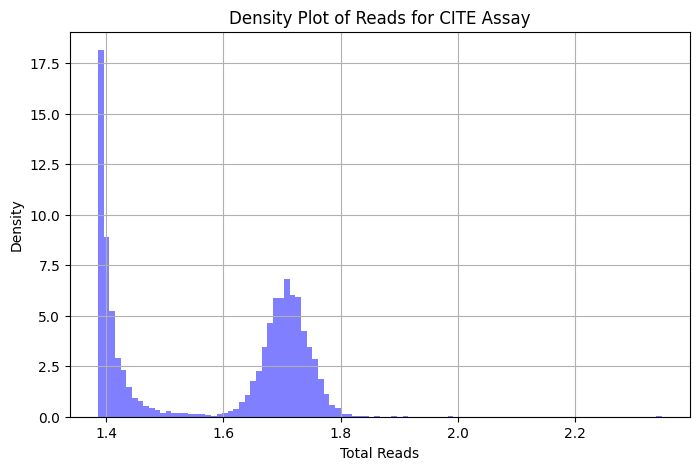

In [45]:
# Extract the CITE assay data from adata.obsm
cite_data = adata.obsm["CITE_clr"]

# Calculate the total reads per cell (column sum)
if sp.issparse(cite_data):
    total_reads = np.array(cite_data.sum(axis=1)).flatten()  # Sum along rows (cells)
else:
    total_reads = cite_data.sum(axis=1)

# Create density plot
plt.figure(figsize=(8, 5))
plt.hist(total_reads, bins=100, density=True, alpha=0.5, color="blue")  # Histogram with density scaling
plt.xlabel("Total Reads")
plt.ylabel("Density")
plt.title("Density Plot of Reads for CITE Assay")
plt.grid(True)
plt.show()

In [61]:
# Ensure CITE feature names are stored as a NumPy array
cite_features = np.array(adata.uns["CITE_features"])

# Find the index of the "Hash" feature in the CITE assay
hash_index = np.where(cite_features == "Hash")[0][0]

# Extract 'Hash' counts from the CITE-seq matrix
if sp.issparse(adata.obsm["CITE_clr"]):
    hash_counts = adata.obsm["CITE_clr"][:, hash_index].toarray().flatten()  # Convert to dense then flatten
else:
    hash_counts = adata.obsm["CITE_clr"][:, hash_index].flatten()

# Store the extracted counts in adata.obs
adata.obs["HashCounts"] = hash_counts

In [ ]:
# Create 'manual_hash_dmux' based on HashCounts threshold
adata.obs["manual_hash_dmux"] = np.where(adata.obs["HashCounts"] > 1.5, "CITE_hash", "Negative")
adata.obs["manual_hash_dmux"].value_counts()


In [ ]:
# Sum total dextramer counts per cell and store in .obs
adata.obs["Dextramer_total_counts"] = adata.obsm["Dextramer"].sum(axis=1)

# Verify the new column
print(adata.obs["Dextramer_total_counts"].head())


AAACCTGAGAGACTAT-1    1953
AAACCTGAGCCAGTAG-1      75
AAACCTGAGGAGTTGC-1    2263
AAACCTGAGTACGACG-1      94
AAACCTGCACAGTCGC-1     106
Name: Dextramer_total_counts, dtype: int64


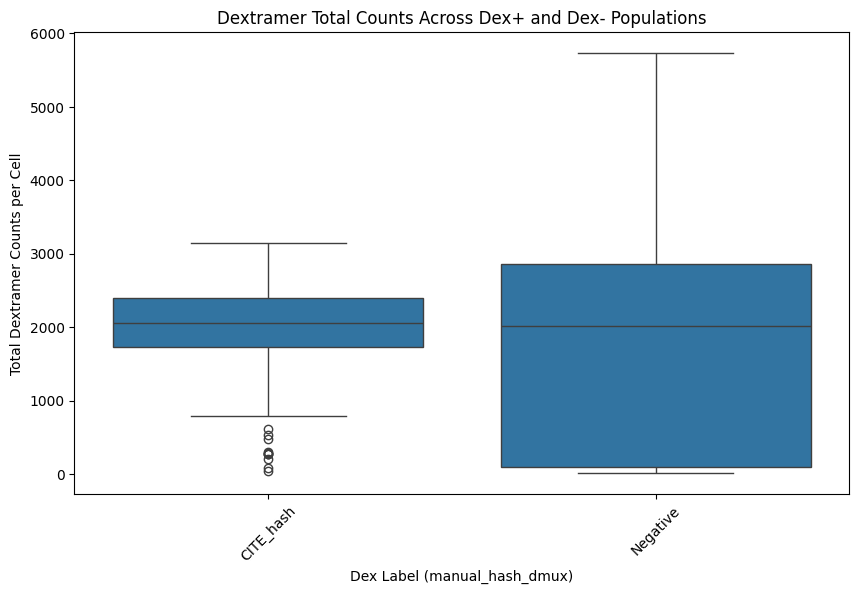

In [91]:
# Create a boxplot of Dextramer total counts grouped by manual_hash_dmux categories
plt.figure(figsize=(10, 6))
sns.boxplot(data=adata.obs, x="manual_hash_dmux", y="Dextramer_total_counts")

# Customize plot labels and title
plt.xlabel("Dex Label (manual_hash_dmux)")
plt.ylabel("Total Dextramer Counts per Cell")
plt.title("Dextramer Total Counts Across Dex+ and Dex- Populations")

# Rotate x-axis labels if necessary for readability
plt.xticks(rotation=45)

plt.show()


Start building the feature set

In [95]:
# Extract dextramer matrix and convert to dense format
dex_matrix = adata.obsm["Dextramer"].toarray()  # Convert sparse matrix to dense

# Compute mean and standard deviation for each dextramer feature
dex_mean = np.mean(dex_matrix, axis=0)  # Mean per dextramer
dex_std = np.std(dex_matrix, axis=0)    # Std per dextramer

# Apply Z-score normalization per dextramer
dex_zscore = (dex_matrix - dex_mean) / dex_std

# Store the normalized dextramer signals back in adata
adata.obsm["Dextramer_zscore"] = dex_zscore

# Verify normalization by checking mean and std
zscore_means = np.mean(dex_zscore, axis=0)  # Should be close to 0
zscore_stds = np.std(dex_zscore, axis=0)    # Should be close to 1

# Print sanity check results
print("Mean of Z-scored dextramers (should be ~0):", zscore_means[:5])
print("Std of Z-scored dextramers (should be ~1):", zscore_stds[:5])

Mean of Z-scored dextramers (should be ~0): [-1.54932450e-16 -1.37823574e-16 -7.64832656e-17  6.80916411e-17
  2.53388156e-16]
Std of Z-scored dextramers (should be ~1): [1. 1. 1. 1. 1.]


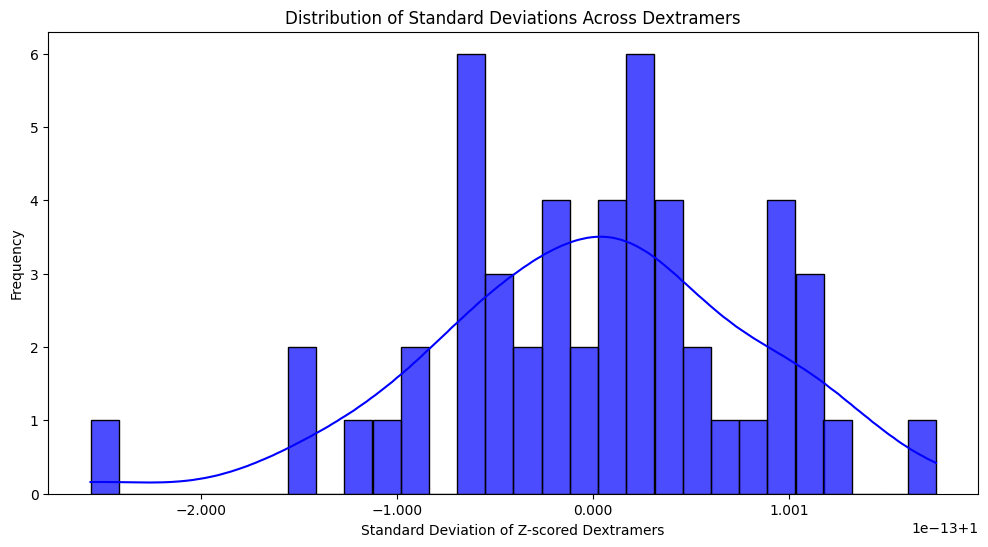

Top 10 dextramers with highest standard deviation:
   Dextramer  Standard_Deviation
19  SRSF2_21                 1.0
31  SRSF2_33                 1.0
44  SRSF2_46                 1.0
28  SRSF2_30                 1.0
10  SRSF2_12                 1.0
36  SRSF2_38                 1.0
21  SRSF2_23                 1.0
13  SRSF2_15                 1.0
40  SRSF2_42                 1.0
29  SRSF2_31                 1.0


In [97]:

# Compute standard deviation for each dextramer after Z-score normalization
dex_std_values = np.std(adata.obsm["Dextramer_zscore"], axis=0)

# Convert to DataFrame for easier plotting
dex_std_df = pd.DataFrame({"Dextramer": adata.uns["Dextramer_features"], "Standard_Deviation": dex_std_values})

# Plot standard deviation distribution
plt.figure(figsize=(12, 6))
sns.histplot(dex_std_df["Standard_Deviation"], bins=30, kde=True, color="blue", alpha=0.7)

plt.xlabel("Standard Deviation of Z-scored Dextramers")
plt.ylabel("Frequency")
plt.title("Distribution of Standard Deviations Across Dextramers")
plt.show()

# Print top dextramers with highest standard deviation
dex_std_df_sorted = dex_std_df.sort_values(by="Standard_Deviation", ascending=False)
print("Top 10 dextramers with highest standard deviation:")
print(dex_std_df_sorted.head(10))

In [117]:

# Extract dextramer matrix as dense array
dex_matrix = adata.obsm["Dextramer"].toarray()

# Extract Dex+ and Dex- labels
dex_labels = adata.obs["manual_hash_dmux"]

# Identify Dex- cells (assumed to be background)
dex_neg_cells = dex_labels == "CITE_hash"  

# Compute the mean background signal for each dextramer using only Dex- cells
dex_background = dex_matrix[dex_neg_cells].mean(axis=0)  # Mean per dextramer in Dex- cells

# Normalize dextramer signals by their background (Fold-Change Enrichment)
dex_fold_change = dex_matrix / dex_background

# Apply log transformation to reduce extreme values (optional but recommended)
dex_log_fc = np.log1p(dex_fold_change)  # log(1 + x) transformation

# Store the background-normalized dextramer signals back in adata
adata.obsm["Dextramer_norm"] = dex_log_fc

# Print sanity check
print("Shape of normalized dextramer matrix:", adata.obsm["Dextramer_norm"].shape)
print("First few values of a random dextramer after normalization:\n", dex_log_fc[:, 0][:5])

Shape of normalized dextramer matrix: (7991, 51)
First few values of a random dextramer after normalization:
 [0. 0. 0. 0. 0.]


/var/folders/tr/vn7tq20j5757j67mf5gf2xg80000gp/T/ipykernel_25586/135871384.py:14: RuntimeWarning: divide by zero encountered in divide
  dex_fold_change = dex_matrix / dex_background
/var/folders/tr/vn7tq20j5757j67mf5gf2xg80000gp/T/ipykernel_25586/135871384.py:14: RuntimeWarning: invalid value encountered in divide
  dex_fold_change = dex_matrix / dex_background


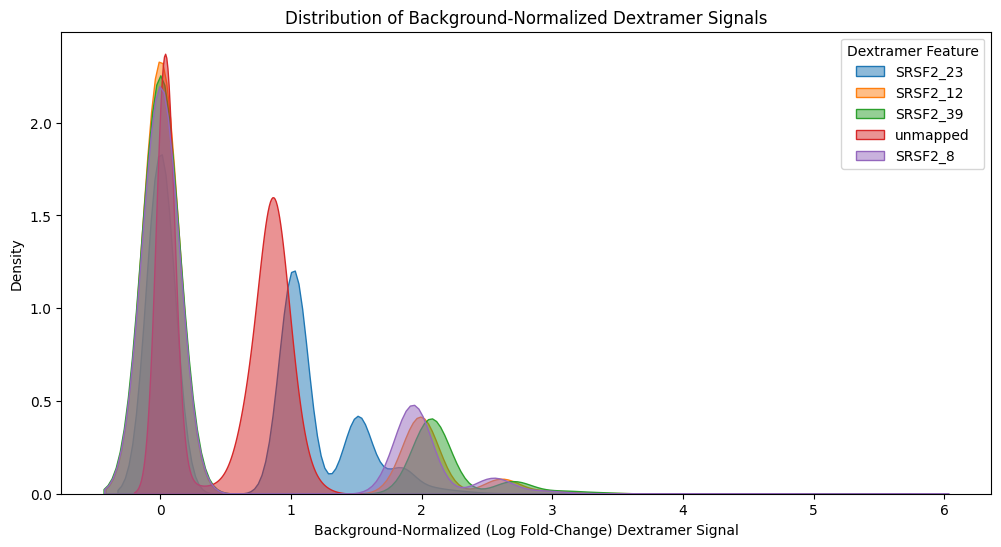

In [118]:
# Select a few dextramers to visualize (randomly choosing 5 for now)
num_features = adata.obsm["Dextramer_norm"].shape[1]
selected_dextramers = np.random.choice(num_features, size=5, replace=False)

# Convert the selected dextramers into a DataFrame for easier plotting
dex_norm_df = pd.DataFrame(adata.obsm["Dextramer_norm"][:, selected_dextramers],
                           columns=[adata.uns["Dextramer_features"][i] for i in selected_dextramers])

# Plot the density distribution of the selected dextramer signals
plt.figure(figsize=(12, 6))
for col in dex_norm_df.columns:
    sns.kdeplot(dex_norm_df[col], label=col, fill=True, alpha=0.5)

plt.xlabel("Background-Normalized (Log Fold-Change) Dextramer Signal")
plt.ylabel("Density")
plt.title("Distribution of Background-Normalized Dextramer Signals")
plt.legend(title="Dextramer Feature")
plt.show()

In [135]:
# Extract TCR clonotype IDs and Dex+/- labels
clonotypes = adata.obs["raw_clonotype_id"]
dex_labels = adata.obs["manual_hash_dmux"]

# Identify Dex+ and Dex- cells based on corrected labels
dex_pos_mask = dex_labels == "Negative"  # Dex+ group
dex_neg_mask = dex_labels == "CITE_hash"  # Dex- group

# Compute total number of cells in each group
total_dex_pos = np.sum(dex_pos_mask)
total_dex_neg = np.sum(dex_neg_mask)

# Count occurrences of each clonotype in Dex+ and Dex- cells
clonotype_counts = pd.DataFrame({
    "Dex+ Count": clonotypes[dex_pos_mask].value_counts(),
    "Dex- Count": clonotypes[dex_neg_mask].value_counts()
}).fillna(0)


# Compute frequency (proportion) in each group
clonotype_counts["Dex+ Frequency"] = clonotype_counts["Dex+ Count"] / total_dex_pos
clonotype_counts["Dex- Frequency"] = clonotype_counts["Dex- Count"] / total_dex_neg

# Compute fold-change enrichment (log-scaled for better interpretability)
clonotype_counts["Enrichment Ratio"] = clonotype_counts["Dex+ Frequency"] / (clonotype_counts["Dex- Frequency"] + 1e-6)
clonotype_counts["Log Enrichment"] = np.log2(clonotype_counts["Enrichment Ratio"] + 1e-6)


# Store results in adata for later use
adata.uns["clonotype_enrichment"] = clonotype_counts

In [136]:
# Print top TCR clonotypes with highest enrichment
print("Top 10 TCR clonotypes enriched in Dex+ cells:")
print(clonotype_counts.sort_values(by="Log Enrichment", ascending=False).head(10))


Top 10 TCR clonotypes enriched in Dex+ cells:
                  Dex+ Count  Dex- Count  Dex+ Frequency  Dex- Frequency  \
raw_clonotype_id                                                           
clonotype16             57.0         0.0        0.007665             0.0   
clonotype24             41.0         0.0        0.005514             0.0   
clonotype27             35.0         0.0        0.004707             0.0   
clonotype29             25.0         0.0        0.003362             0.0   
clonotype33             24.0         0.0        0.003228             0.0   
clonotype41             19.0         0.0        0.002555             0.0   
clonotype49             16.0         0.0        0.002152             0.0   
clonotype54             15.0         0.0        0.002017             0.0   
clonotype56             14.0         0.0        0.001883             0.0   
clonotype60             13.0         0.0        0.001748             0.0   

                  Enrichment Ratio  Log E

Here we have normalized compared to Dex- but is this the full story? Is there not also something curious about the 'real' signal being a too cohesive pattern across TCRs?